# Compute effect of shape on PAC
* Fit monotonic splines between each peak and trough (no gamma!)
* Compute PAC in original and spline signals
* What proportion of the PAC in original signal is explained by PAC in spline signal (compared to randomly shuffled phase/amp time series) (NOT IMPLEMENTED)

# Findings
* Forcing the signal to be monotonic between peaks and troughs actually increases the PAC slightly. This is likely not just due to some periods of noise in which the splien fitting was poor overwelming legitimate PAC.

**Imports**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('white')

In [2]:
import util
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import UnivariateSpline

**Load data**

In [3]:
ecog = util.loadPD()
Fs, t, S, Sdy, flo, fhi = util.loadmeta()

### Compute PAC on original signal

In [4]:
pac = util.measure_pac(ecog, flo, fhi, Fs=Fs)

# Interpolate ECoG signals with splines
* Only 'B' signals, before DBS

In [5]:
from shape import findpt
boundaryS = 100

ecog_spline = np.zeros(S, dtype=np.ndarray)
for s in range(S):
    # Locate peaks and troughs
    ecog_spline[s] = np.copy(ecog['B'][s])
    x = np.copy(ecog['B'][s])
    Ps, Ts = findpt(x, flo, Fs=Fs, boundary=boundaryS)
    
    # Force to start and end at peak
    if Ps[0] > Ts[0]:
        Ts = Ts[1:]
    if Ps[-1] < Ts[-1]:
        Ts = Ts[:-1]
        
    for i in range(len(Ts)):
        # Determine short signal to fit
        y = -x[Ps[i]:Ts[i]+1]
        if len(y) > 3:
        
            # Fit short signal
            ir = IsotonicRegression()
            y_ = ir.fit_transform(np.arange(len(y)), y)
            spl = UnivariateSpline(np.arange(len(y)), y_)
            spl.set_smoothing_factor(1)
            y_ = spl(np.arange(len(y)))

            # Add short fitted signal to whole fitted signal
            ecog_spline[s][Ps[i]:Ts[i]+1] = -y_
        else:
            ecog_spline[s][Ps[i]:Ts[i]+1] = y

        # Repeat process for trough to peak
        y = x[Ts[i]:Ps[i+1]+1]
        if len(y) > 3:
            ir = IsotonicRegression()
            y_ = ir.fit_transform(np.arange(len(y)), y)
            spl = UnivariateSpline(np.arange(len(y)), y_)
            spl.set_smoothing_factor(1)
            y_ = spl(np.arange(len(y)))
            ecog_spline[s][Ts[i]:Ps[i+1]+1] = y_
        else:
            ecog_spline[s][Ts[i]:Ps[i+1]+1] = y

# Compare original and interpolated signals

(5000, 7000)

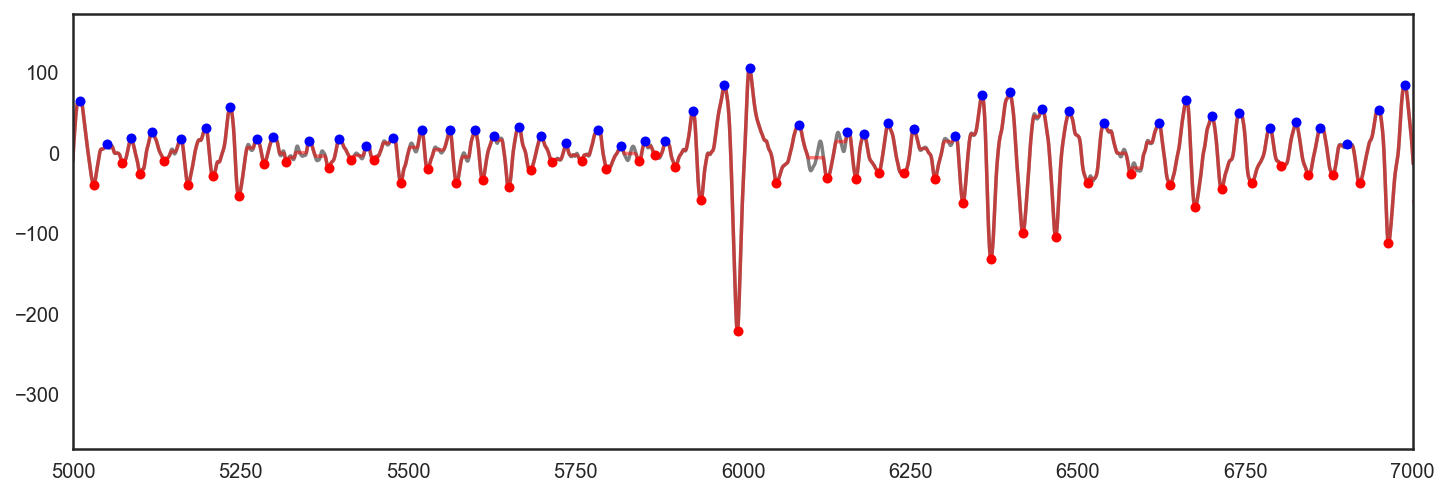

In [6]:
s = 22
tlims = (5000, 7000)

plt.figure(figsize=(12,4))
plt.plot(ecog['B'][s], 'k', alpha=.5)
plt.plot(ecog_spline[s], 'r', alpha=.5)
plt.plot(Ps,ecog['B'][s][Ps], 'bo', ms=5)
plt.plot(Ts,ecog['B'][s][Ts], 'ro', ms=5)
plt.xlim(tlims)

# Compute PAC for interpolated signals

In [7]:
ecog_spline = {'B': ecog_spline, 'D': ecog_spline}
pac_spline = util.measure_pac(ecog_spline, flo, fhi, Fs=Fs)
ecog_spline = ecog_spline['B']
pac_spline = pac_spline['B']

# Compare PAC in original and spline signals

Ttest_relResult(statistic=-6.2149596150883255, pvalue=2.9601150658178338e-06)


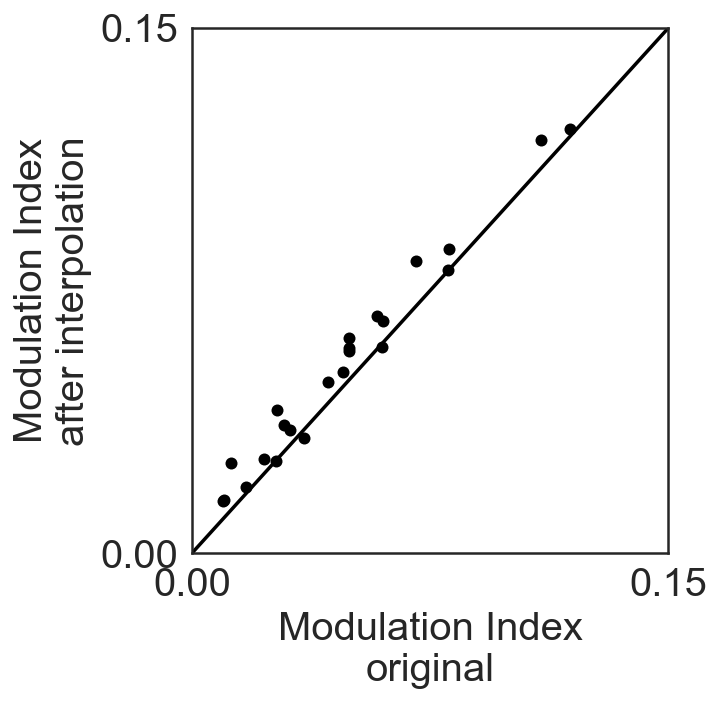

In [8]:
# DBS decreases PAC
from plt import scatt_2cond
scatt_2cond(pac['B'],pac_spline,ms=12,
           lims = (0,.15), xlabel = 'Modulation Index\noriginal',
            ylabel = 'Modulation Index\nafter interpolation',figsize=(5,5))
plt.tick_params(labelsize=20)

print(sp.stats.ttest_rel(pac['B'],pac_spline))